In [3]:
import tensorflow as tf
import time

# Check available GPUs
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpus)

# Function to measure execution time
def benchmark(device):
    with tf.device(device):
        # Create large random matrices
        a = tf.random.normal([1000, 1000])
        b = tf.random.normal([1000, 1000])
        
        # Measure time
        start_time = time.time()
        c = tf.matmul(a, b)  # Matrix multiplication
        tf.keras.backend.clear_session()  # Free up memory
        end_time = time.time()
        
    return end_time - start_time

# Run benchmarks
cpu_time = benchmark('/CPU:0')
gpu_time = benchmark('/GPU:0') if gpus else None

# Display results
print(f"CPU time: {cpu_time:.6f} seconds")
if gpu_time:
    print(f"GPU time: {gpu_time:.6f} seconds")
    print(f"Speedup Factor (CPU/GPU): {cpu_time/gpu_time:.2f}x")
else:
    print("GPU not available. Running only on CPU.")


Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
CPU time: 0.101858 seconds
GPU time: 0.083936 seconds
Speedup Factor (CPU/GPU): 1.21x


# Comparing Biased and Unbiased Models

### Import necessary libraries

In [4]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt

### Load biased and unbiased datasets

In [5]:
# Constants
IMG_SIZE = 128  # Resize images to 128x128

# Function to load images and labels
def load_dataset_with_bias(bias):

    if bias:
        DATASET_PATH = "./face_dataset/Dataset/test_biased_data"
    else:
        DATASET_PATH = "./face_dataset/Dataset/test_unbiased_data/"

    data = []
    labels = []
    categories = ["male", "female"]  # Define classes
    
    for category in categories:
        path = os.path.join(DATASET_PATH, category)  # Path to male/female folders
        label = categories.index(category)  # Assign 0 to male, 1 to female
        
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            
            # Read and preprocess image
            img = cv2.imread(img_path)

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))  # Resize to 128x128
            img = img / 255.0  # Normalize pixel values
            
            data.append(img)
            labels.append(label)
    
    return np.array(data), np.array(labels)

# Load dataset
X_biased, y_biased = load_dataset_with_bias(bias=True)
X_unbiased, y_unbiased = load_dataset_with_bias(bias=False)


print(f"Biased Dataset Loaded: {X_biased.shape[0]} images")
print(f"Unbiased Dataset Loaded: {X_unbiased.shape[0]} images")

Biased Dataset Loaded: 4500 images
Unbiased Dataset Loaded: 7500 images


## Test the Unbiased Model

### Split data to training-testing samples (unbiased)

In [6]:
X_train_unbiased, X_test_unbiased, y_train_unbiased, y_test_unbiased = train_test_split(X_unbiased, y_unbiased, test_size=0.2, random_state=42)

print(f"Unbiased Train Set: {X_train_unbiased.shape[0]} images")
print(f"Unbiased Test Set: {X_test_unbiased.shape[0]} images")

Unbiased Train Set: 6000 images
Unbiased Test Set: 1500 images


### Define the CNN Model - Unbiased

In [7]:
unbiased_model = tf.keras.Sequential([
    # First Conv Block
    tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    # Second Conv Block
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    # Third Conv Block
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    # Fourth Conv Block
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    # Flatten to Fully Connected Layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4),  # Increase dropout to reduce overfitting
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary Classification Output
])

# Compile the Model
unbiased_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Show Model Summary
unbiased_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,782,913 (10.62 MB)

 Trainable params: 2,781,953 (10.61 MB)

 Non-trainable params: 960 (3.75 KB)

### Train the Unbiased Model

In [23]:
unbiased_model.fit(X_train_unbiased, y_train_unbiased, epochs=10, validation_data=(X_test_unbiased, y_test_unbiased))

Epoch 1/10


I0000 00:00:1739962945.153815   24154 service.cc:148] XLA service 0x7e81a0014d00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1739962945.154145   24154 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-02-19 16:32:25.209329: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1739962945.492746   24154 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/188 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.5559 - loss: 1.4616

I0000 00:00:1739962949.573992   24154 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - accuracy: 0.6528 - loss: 1.1493 - val_accuracy: 0.4833 - val_loss: 1.2012
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.8717 - loss: 0.3099 - val_accuracy: 0.6120 - val_loss: 0.7902
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.9257 - loss: 0.1916 - val_accuracy: 0.9153 - val_loss: 0.2074
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.9350 - loss: 0.1704 - val_accuracy: 0.8760 - val_loss: 0.2983
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.9492 - loss: 0.1431 - val_accuracy: 0.9227 - val_loss: 0.1900
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.9634 - loss: 0.1059 - val_accuracy: 0.9407 - val_loss: 0.1607
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9621 - loss: 0.1032 - val_accuracy: 0.9420 - val_loss: 0.1567
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.9772 - loss: 0.0625 - val_accuracy: 0.95

### Evaluate Model on Test Data

In [24]:
unbiased_model.evaluate(X_test_unbiased, y_test_unbiased)

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9525 - loss: 0.1295


[0.12938480079174042, 0.9506666660308838]

### Use model to predict new images

In [25]:
def predict_gender_unbiased(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    prediction = unbiased_model.predict(img)[0][0]
    gender = "Female" if prediction > 0.5 else "Male"
    print(prediction)
    print(f"Predicted Gender: {gender}")

In [26]:
predict_gender_unbiased("./test_images/grande.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
0.9745976
Predicted Gender: Female


## Test the Biased Model

### Split data to training-testing samples (biased)

In [27]:
X_train_biased, X_test_biased, y_train_biased, y_test_biased = train_test_split(X_biased, y_biased, test_size=0.2, random_state=42)

print(f"Biased Train Set: {X_train_biased.shape[0]} images")
print(f"Biased Test Set: {X_test_biased.shape[0]} images")

Biased Train Set: 3600 images
Biased Test Set: 900 images


### Define the CNN Model - Biased

In [28]:
biased_model = tf.keras.Sequential([
    # First Conv Block
    tf.keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    # Second Conv Block
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    # Third Conv Block
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    # Fourth Conv Block
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    # Flatten to Fully Connected Layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4),  # Increase dropout to reduce overfitting
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary Classification Output
])

# Compile the Model
biased_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Show Model Summary
biased_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 61, 61, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     2,359,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,782,913 (10.62 MB)

 Trainable params: 2,781,953 (10.61 MB)

 Non-trainable params: 960 (3.75 KB)

### Train the Biased Model

In [29]:
biased_model.fit(X_train_biased, y_train_biased, epochs=10, validation_data=(X_test_biased, y_test_biased))

Epoch 1/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.8178 - loss: 0.9258 - val_accuracy: 0.8778 - val_loss: 0.8392
Epoch 2/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8619 - loss: 0.4466 - val_accuracy: 0.8789 - val_loss: 0.4941
Epoch 3/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8837 - loss: 0.3574 - val_accuracy: 0.8778 - val_loss: 0.5890
Epoch 4/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8910 - loss: 0.2917 - val_accuracy: 0.8811 - val_loss: 0.3497
Epoch 5/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9010 - loss: 0.2449 - val_accuracy: 0.9133 - val_loss: 0.2001
Epoch 6/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9373 - loss: 0.1551 - val_accuracy: 0.9122 - val_loss: 0.2177
Epoch 7/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9511 - loss: 0.1192 - val_accuracy: 0.9300 - val_loss: 0.1491
Epoch 8/10
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9635 - loss: 0.0943 - val_acc

### Evaluate Model on Test Data

In [30]:
biased_model.evaluate(X_test_biased, y_test_biased)

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9504 - loss: 0.1404


[0.12277432531118393, 0.95333331823349]

### Use Model to predict new images

In [31]:
def predict_gender_biased(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    prediction = biased_model.predict(img)[0][0]
    gender = "Female" if prediction >= 0.5 else "Male"
    print(prediction)
    print(f"Predicted Gender: {gender}")

In [32]:
predict_gender_biased("./test_images/cavill.jpg")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
0.36452764
Predicted Gender: Male


### Testing model on new set of images

In [33]:
def load_new_data(gender):
    data = []
    test_dir = ""

    if gender:
        test_dir = "testing_images_female"
    else:
        test_dir = "testing_images_male"

    
    for img_name in os.listdir(test_dir):
        img = cv2.imread(f'{test_dir}/{img_name}')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0

        data.append(img)
    
    return np.array(data)

#### ACCURACY USING UNBIASED MODEL

In [34]:
unbiased_test_female = load_new_data(1)
unbiased_test_male = load_new_data(0)


print(f"New Data Loaded: {unbiased_test_female.shape[0]} images")
print(f"New Data Loaded: {unbiased_test_male.shape[0]} images")

New Data Loaded: 100 images
New Data Loaded: 100 images


In [35]:
male_preds = unbiased_model.predict(unbiased_test_male)
female_preds = unbiased_model.predict(unbiased_test_female)

male_preds = [0 if p < 0.5 else 1 for p in male_preds]  # Male should be 0
female_preds = [0 if p < 0.5 else 1 for p in female_preds]  # Female should be 1


male_accuracy = (sum([1 for p in male_preds if p == 0]) / len(unbiased_test_male)) * 100
female_accuracy = (sum([1 for p in female_preds if p == 1]) / len(unbiased_test_female)) * 100

print(f"Male Accuracy: {male_accuracy:.2f}%")
print(f"Female Accuracy: {female_accuracy:.2f}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Male Accuracy: 94.00%
Female Accuracy: 98.00%


#### ACCURACY USING BIASED MODEL

In [36]:
biased_test_female = load_new_data(1)
biased_test_male = load_new_data(0)


print(f"New Data Loaded: {unbiased_test_female.shape[0]} images")
print(f"New Data Loaded: {unbiased_test_male.shape[0]} images")

New Data Loaded: 100 images
New Data Loaded: 100 images


In [37]:
male_preds = biased_model.predict(biased_test_male)
female_preds = biased_model.predict(biased_test_female)

male_preds = [0 if p < 0.5 else 1 for p in male_preds]  # Male should be 0
female_preds = [0 if p < 0.5 else 1 for p in female_preds]  # Female should be 1


male_accuracy = (sum([1 for p in male_preds if p == 0]) / len(unbiased_test_male)) * 100
female_accuracy = (sum([1 for p in female_preds if p == 1]) / len(unbiased_test_female)) * 100

print(f"Male Accuracy: {male_accuracy:.2f}%")
print(f"Female Accuracy: {female_accuracy:.2f}%")

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Male Accuracy: 74.00%
Female Accuracy: 100.00%


In [38]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def predict_gender(image_path):
    # Load image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV default) to RGB
    img_resized = cv2.resize(img, (128, 128))  # Resize
    img_normalized = img_resized / 255.0  # Normalize
    img_input = np.expand_dims(img_normalized, axis=0)  # Add batch dimension

    # Predict using both models
    biased_prediction = biased_model.predict(img_input)[0][0]
    unbiased_prediction = unbiased_model.predict(img_input)[0][0]

    
    biased_gender = "Female" if biased_prediction >= 0.5 else "Male"
    unbiased_gender = "Female" if unbiased_prediction >= 0.5 else "Male"

    print(f"Biased Model Predicted Gender: {biased_gender} ({biased_prediction:.2f})")
    print(f"Unbiased Model Predicted Gender: {unbiased_gender} ({unbiased_prediction:.2f})")
    print("_ _ _")

    # Display results (only one image)
    fig, ax = plt.subplots(figsize=(6, 6))  # Single plot
    ax.imshow(img)  # Show the original image
    ax.set_title(
        
        f"Biased: {biased_gender} ({biased_prediction:.2f})\n"
        f"Unbiased: {unbiased_gender} ({unbiased_prediction:.2f})"
    )
    ax.axis("off")

    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Biased Model Predicted Gender: Female (0.91)
Unbiased Model Predicted Gender: Male (0.29)
_ _ _


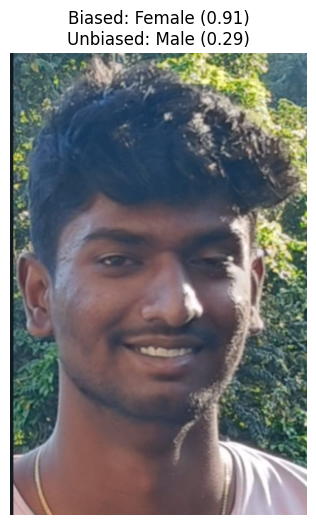

In [46]:
predict_gender("./images/mahesh.png")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Biased Model Predicted Gender: Female (0.72)
Unbiased Model Predicted Gender: Male (0.13)
_ _ _


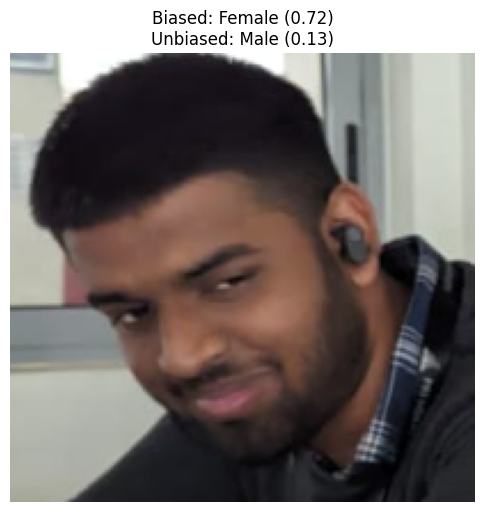

In [48]:

predict_gender("./images/hruthvik.png")

## Graphs and Confusion Matrices for Comparison

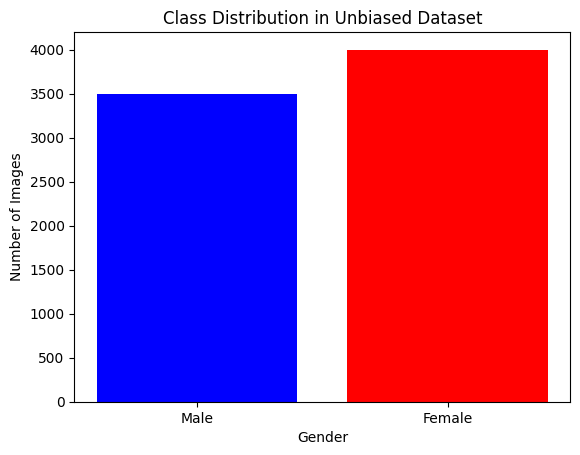

In [49]:
import matplotlib.pyplot as plt

labels, counts = np.unique(y_unbiased, return_counts=True)
plt.bar(["Male", "Female"], counts, color=["blue", "red"])
plt.xlabel("Gender")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Unbiased Dataset")
plt.show()


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step


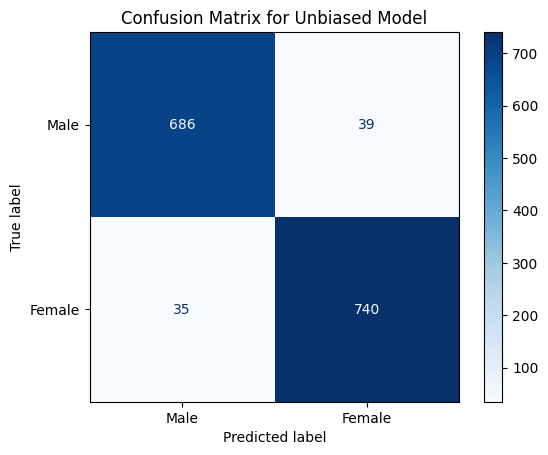

In [50]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get all predictions
y_pred_probs = unbiased_model.predict(X_test_unbiased).flatten()
y_pred = [1 if p >= 0.5 else 0 for p in y_pred_probs]  # Convert to binary labels

# Compute confusion matrix
cm = confusion_matrix(y_test_unbiased, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Male", "Female"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix for Unbiased Model")
plt.show()


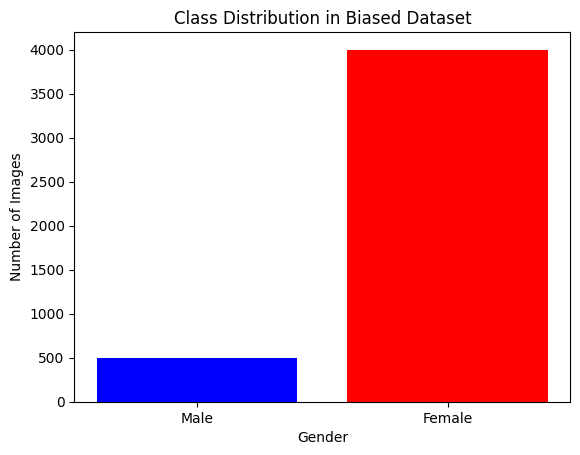

In [51]:
import matplotlib.pyplot as plt

labels, counts = np.unique(y_biased, return_counts=True)
plt.bar(["Male", "Female"], counts, color=["blue", "red"])
plt.xlabel("Gender")
plt.ylabel("Number of Images")
plt.title("Class Distribution in Biased Dataset")
plt.show()


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


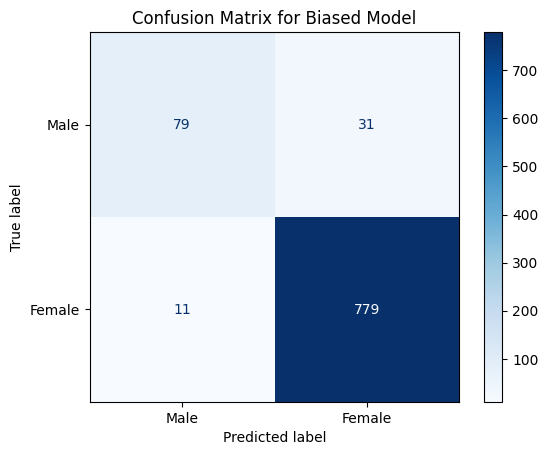

In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get all predictions
y_pred_probs = biased_model.predict(X_test_biased).flatten()
y_pred = [1 if p >= 0.5 else 0 for p in y_pred_probs]  # Convert to binary labels

# Compute confusion matrix
cm = confusion_matrix(y_test_biased, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Male", "Female"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix for Biased Model")
plt.show()


## SAVE THE MODELS

In [ ]:
# biased_model.save("21425_biased_model.keras")
# unbiased_model.save("21425_unbiased_model.keras")

In [ ]:
biased_model_old = tf.keras.models.load_model("21425_biased_model.keras")
unbiased_model_old = tf.keras.models.load_model("21425_unbiased_model.keras")

/home/anirudh-sandilya/.pyenv/versions/3.10.12/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 24 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def predict_gender_old(image_path):
    # Load image
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR (OpenCV default) to RGB
    img_resized = cv2.resize(img, (128, 128))  # Resize
    img_normalized = img_resized / 255.0  # Normalize
    img_input = np.expand_dims(img_normalized, axis=0)  # Add batch dimension

    # Predict using both models
    biased_prediction = biased_model_old.predict(img_input)[0][0]
    unbiased_prediction = unbiased_model_old.predict(img_input)[0][0]

    
    biased_gender = "Female" if biased_prediction >= 0.5 else "Male"
    unbiased_gender = "Female" if unbiased_prediction >= 0.5 else "Male"

    print(f"Biased Model Predicted Gender: {biased_gender} ({biased_prediction:.2f})")
    print(f"Unbiased Model Predicted Gender: {unbiased_gender} ({unbiased_prediction:.2f})")
    print("_ _ _")

    # Display results (only one image)
    fig, ax = plt.subplots(figsize=(6, 6))  # Single plot
    ax.imshow(img)  # Show the original image
    ax.set_title(
        f"Actual: Male\n"
        f"Biased: {biased_gender} ({biased_prediction:.2f})\n"
        f"Unbiased: {unbiased_gender} ({unbiased_prediction:.2f})"
    )
    ax.axis("off")

    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Biased Model Predicted Gender: Female (0.70)
Unbiased Model Predicted Gender: Male (0.00)
_ _ _


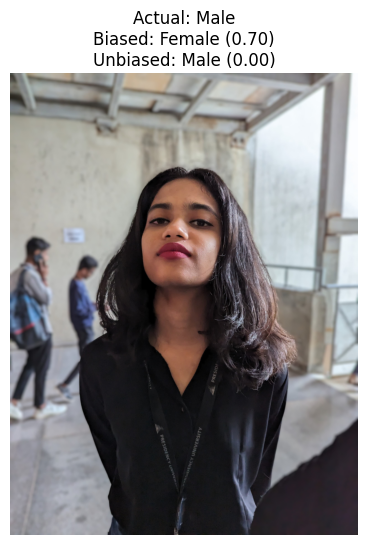

In [ ]:
predict_gender_old("./images/weird_perepi.png")

In [ ]:
biased_model_old.evaluate(X_test_biased, y_test_biased)
unbiased_model_old.evaluate(X_test_unbiased, y_test_unbiased)

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.8155 - loss: 0.9731
38/38 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.8003 - loss: 0.5760


[0.6237215399742126, 0.784166693687439]

# Rough tests (IGNORE)

In [ ]:
def load_new_data():
    data = []
    
    for img_name in os.listdir('images'):
        img = cv2.imread(f'images/{img_name}')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        img = img / 255.0

        data.append(img)
    
    return np.array(data)

X_new = load_new_data()
print(f"New Data Loaded: {X_new.shape[0]} images")


New Data Loaded: 21 images


In [ ]:
test_pred = unbiased_model_old.predict(X_new)

print(test_pred)

test_pred = [0 if p < 0.5 else 1 for p in test_pred]
test_pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
[[9.3988387e-04]
 [1.6850196e-02]
 [4.3973796e-02]
 [6.5899605e-04]
 [6.3597258e-06]
 [1.8118678e-03]
 [1.1647121e-02]
 [5.2115382e-03]
 [1.2086812e-01]
 [4.3184488e-04]
 [2.4101363e-02]
 [1.2958713e-01]
 [9.6322652e-03]
 [7.7365508e-04]
 [3.9821276e-01]
 [4.3408971e-04]
 [3.6497184e-03]
 [3.0336011e-04]
 [6.1803825e-05]
 [4.8972243e-03]
 [5.8079150e-04]]


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 912ms/step


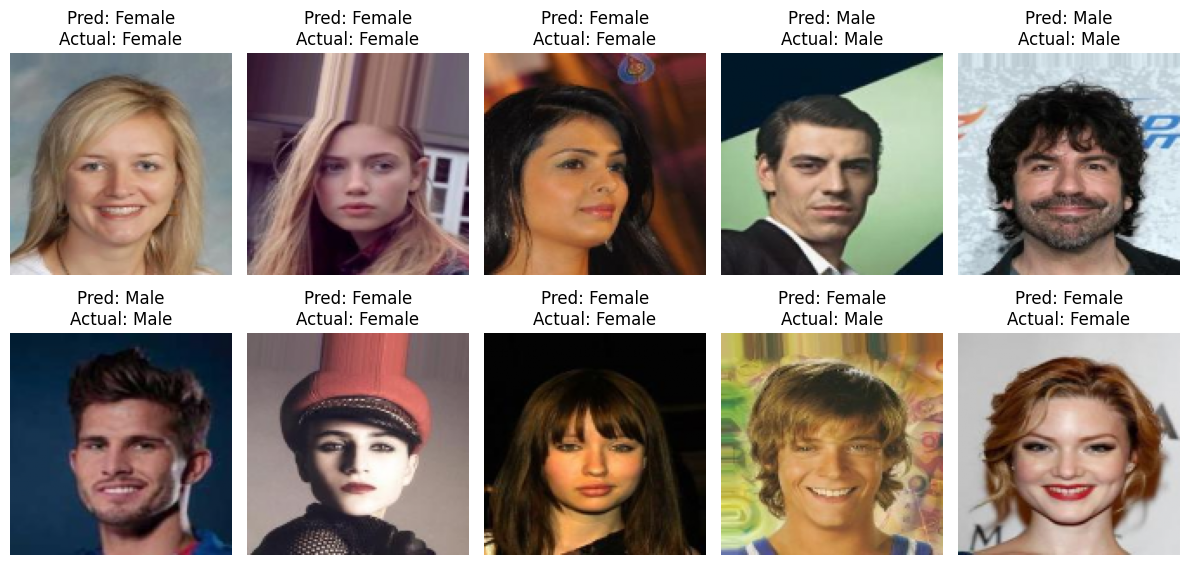

In [53]:
import random

# Pick 10 random test images
sample_indices = random.sample(range(len(X_test_unbiased)), 10)
sample_images = X_test_unbiased[sample_indices]
sample_labels = y_test_unbiased[sample_indices]

# Get model predictions
predictions = unbiased_model.predict(sample_images).flatten()
predicted_labels = ["Male" if p < 0.5 else "Female" for p in predictions]

# Plot images with predicted labels
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(sample_images[i])
    ax.set_title(f"Pred: {predicted_labels[i]}\nActual: {'Male' if sample_labels[i] == 0 else 'Female'}")
    ax.axis("off")
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


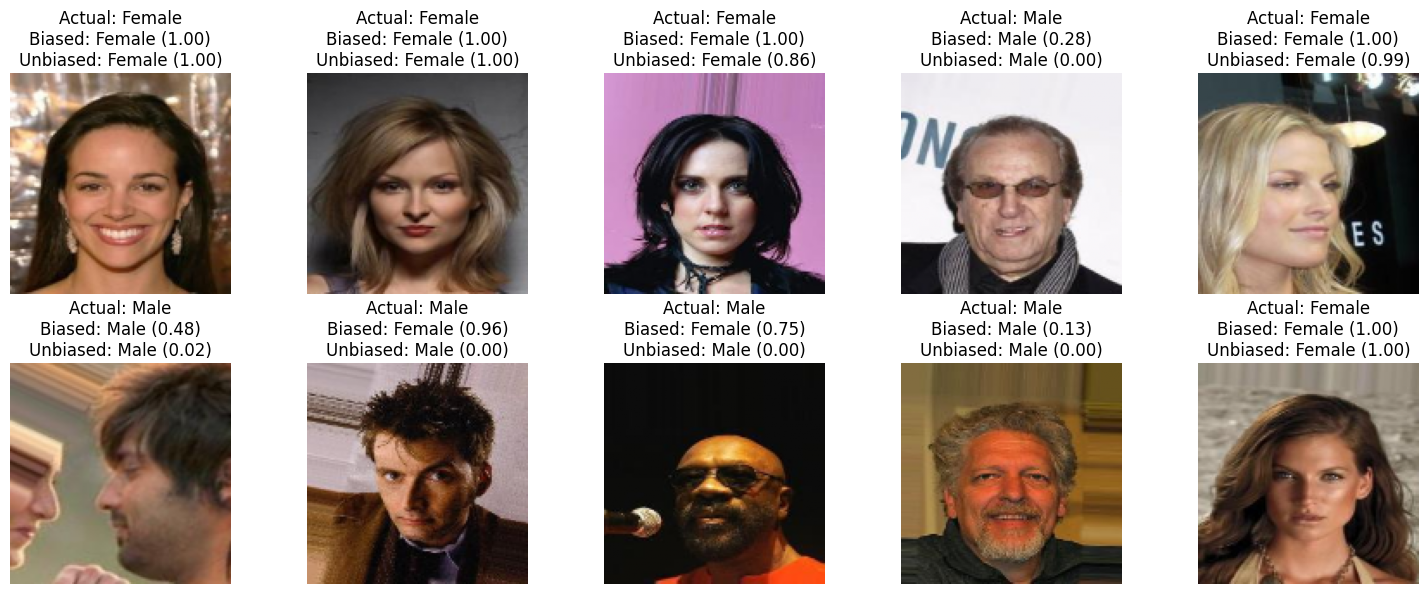

In [59]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Pick 10 random test images
sample_indices = random.sample(range(len(X_test_unbiased)), 10)
sample_images = X_test_unbiased[sample_indices]
sample_labels = y_test_unbiased[sample_indices]

# Get predictions from both models
biased_predictions = biased_model.predict(sample_images).flatten()
unbiased_predictions = unbiased_model.predict(sample_images).flatten()

biased_labels = ["Male" if p < 0.5 else "Female" for p in biased_predictions]
unbiased_labels = ["Male" if p < 0.5 else "Female" for p in unbiased_predictions]
actual_labels = ["Male" if y == 0 else "Female" for y in sample_labels]

# Plot images with predictions
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(sample_images[i])
    ax.set_title(
        f"Actual: {actual_labels[i]}\n"
        f"Biased: {biased_labels[i]} ({biased_predictions[i]:.2f})\n"
        f"Unbiased: {unbiased_labels[i]} ({unbiased_predictions[i]:.2f})"
    )
    ax.axis("off")

plt.tight_layout()
plt.show()
